In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 300

In [2]:
# Read in data that was processed in OpenRefine
FILENAME = "raw-roast-reviews-openrefine.csv"
FILEPATH = os.path.join("data", FILENAME)
df_raw = pd.read_csv(FILEPATH)

In [3]:
def tweak_df(df):
    return (df
            .replace('na', np.nan)
            .dropna(subset=['origin_country_cluster', 'roaster_location', 'roast_level', 'body', 'aroma'])
            .assign(origin_country=lambda df_: (df_['origin_country_cluster']
                                                .str.split(',')
                                                .str[-1]
                                                .str.strip()
                                                ),
                    origin_region=lambda df_: (df_['origin_country_cluster']
                                               .str.split(',')
                                               .str[:-1]
                                               .str.join(',')
                                               .str.strip()
                                               ),
                    review_date = lambda df_: pd.to_datetime(df_['review_date'], format="%B %Y"),
                    acidity = lambda df_: df_['acidity'].fillna(df_['acidity/structure']),
                    agtron_external = lambda df_: (df_['agtron']
                                                   .str.split('/')
                                                   .str[0].str.strip()
                                                   .replace(['', 'NA', 'g', '0'], np.nan)
                                                   ),
                    agtron_ground = lambda df_: (df_['agtron']
                                                 .str.split('/')
                                                 .str[1].str.strip()
                                                 .replace(['', 'NA', 'wb', '0'], np.nan)),
            )
            .drop(columns=['acidity/structure', 'with_milk', 'bottom_line', 'agtron'])
            .dropna(subset=['acidity']) # drop rows where acidity is still NaN, these are espresso reviews
            .rename(columns={'country': 'roaster_country', 'roaster_location': 'roaster_city', 
                             'located in the administrative territorial entity': 'roaster_region',
                             'coordinate location': 'roaster_coordinates'})
            .assign(origin_region=lambda df_: df_['origin_region'].replace('', np.nan))
            .astype({'agtron_external': 'Int64', 'agtron_ground': 'Int64', 'acidity': 'float',
                     'aftertaste': 'Int64', 'aroma': 'float', 'body': 'float',
                     'rating': 'Int64', 'flavor': 'float',})
    )

df = tweak_df(df_raw)

In [8]:
grams_conversions = {
        'ounces': 28.3495,
        'pounds': 453.592,
        'grams': 1,
        'kilograms': 1000
}

currency_map = {
    'CNY': 'CNY',
    '$': 'USD',
    'NT$' : 'TWD',
    'GBP' : 'GBP',
    'HKD$' : 'HKD',
    'Nt$' : 'TWD',
    'RMB' : 'CNY',
    'AED$' : 'AED',
    'KRW$' : 'KRW',
    '£' : 'GBP',
    '$NT$': 'TWD',
    'CAD$' : 'CAD',
    '¥' : 'JPY',
    'pesos' : 'MXN',
    'USD$' : 'USD',
    'US$'  : 'USD',
    '$CAD' : 'CAD',
    'IDR$' : 'IDR',
    'AUD$' : 'AUD',
    '$NT' : 'TWD',
    'NTD$' : 'TWD',
    'NT' : 'TWD',
    'KRW' : 'KRW',
    'RMB$' : 'CNY',
    '$NTD' : 'TWD',
    'CNY$' : 'CNY',
    'THB$' : 'THB',
    'TWD$' : 'TWD',
    'HK$' : 'HKD',
    'E' : 'EUR',
    'GTQ' : 'GTQ',
    'Price:$': 'USD',
    'THB' : 'THB',
 }
# Cleaning up price and units 
quantity = (df['est_price']
 .str.split('[/;]', n=1, expand=True)
 .dropna()
 .rename(columns={0: 'price', 1: 'amount'})
 .loc[:, 'amount']
 .str.replace('oz.*', 'ounces')
 .str.replace('ouncues|onces|ounce$|-ounce|ounces.*$', 'ounces', regex=True)
 .str.replace(r'oz.', 'ounces', regex=False)
 .str.replace(r'g ', 'grams', regex=False)
 .str.replace(r'-gram', ' grams', regex=True)
 .str.replace(r'g. ', 'grams', regex=False)
 .str.replace(r' g.', ' grams', regex=False)
 .str.replace(r'g$', ' grams', regex=True)
 .str.replace(r'\((.*?)\)', '', regex=True)
 .str.replace(r';|\(|\$.*$', '', regex=True)
 .str.replace('tin', '', regex=False)
 .str.replace('  ', ' ', regex=True)
 .str.replace('8 18 grams pouches', '152 grams', regex=False)
 .str.replace('350 grams 12.3 ounces', '350 grams', regex=False)
 .str.strip()
 .mask(lambda x: x.str.contains('capsule|packet|pods|vue|k-cups|sticks|tubes|cups|boxed|discs|can', case=False), np.nan)
 )

quantity_unit= (quantity
                .str.split(' ', expand=True)
                .rename(columns={0: 'quantity', 1: 'unit'})
                # if quantity equals 'pound' set quantity to 1 and unit to pounds
                .assign(unit = lambda df_: df_['unit'].mask(df_['quantity'] == 'pound', 'pounds'),
                        quantity = lambda df_: df_['quantity'].mask(df_['quantity'] == 'pound', 1)
                )
                .astype({'quantity': 'float'})
                # convert all units to grams
                .assign(quantity_grams = lambda df_: df_['quantity'] * df_['unit'].map(grams_conversions))
)

price = (df['est_price']
         .str.split('[/;]', n=1, expand=True)
         .loc[:, 0]
         .str.replace(',', '', regex=False)
         # regex to extract the price from the string
        .str.extract(r'(\d+\.\d+|\d+)')
        .loc[:, 0]
        .astype('float')
        .rename('nominal_price')
)

currency = (df['est_price']
         .str.split('[/;]', n=1, expand=True)
         .loc[:, 0]
         .str.replace(',', '', regex=False)
         # regex to extract the price from the string
        .str.replace(r'(\d+\.\d+|\d+)', '', regex=True)
        .str.strip()
        .str.replace(' ', '')
        .map(currency_map, na_action='ignore')
        .rename('currency')
)

df = df.join(quantity_unit, how='left').join(price, how='left').join(currency, how='left')


ValueError: columns overlap but no suffix specified: Index(['quantity', 'unit', 'quantity_grams'], dtype='object')

In [ ]:
with open('data/exchange_rates.json', 'r') as f:
    exchange_rates = json.load(f)
    
df = (df
      .dropna(subset=['review_date', 'currency'])
      .astype({'review_date': 'str'})
      .assign(exchange_rate = lambda df_: df_.apply(lambda x: exchange_rates[x['review_date']][x['currency']], axis=1))
      .assign(price_usd = lambda df_: df_['nominal_price'] / df_['exchange_rate'])
      .assign(review_date = lambda df_: pd.to_datetime(df_['review_date']))
      .round({'price_usd': 2})
)

In [688]:
# Read in CPI data
def cpi_date(filepath: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(filepath).drop(columns=['HALF1', 'HALF2'])
    except Exception as e:
        print(e)
    return (df
          .melt(id_vars='Year', var_name='Month', value_name='cpi')
          .assign(date=lambda df_: pd.to_datetime(df_['Year'].astype(str) + '-' + df_['Month'], format='mixed'))
          .dropna(subset=['cpi'])
          .sort_values('date')
          .drop(columns=['Year', 'Month'])
    )

cpi = cpi_date('data/cpi.csv')
cpi_jan_2024 = cpi.loc[cpi['date'] == '2024-01-01', 'cpi'].values[0]

In [701]:
(
    df
    .join(cpi.set_index('date'), on='review_date')
    # Past dollars in terms of recent dollars = Dollar amount × Ending-period CPI / Beginning-period CPI.
    .assign(price_USD_2024 = lambda df_: np.round(df_['price_usd'] * cpi_jan_2024 / df_['cpi'], 2))
    .assign(price_USD_2024_per_100g = lambda df_: np.round(df_['price_USD_2024'] / df_['quantity_grams'] * 100, 2))

)

TypeError: '>=' not supported between instances of 'str' and 'float'

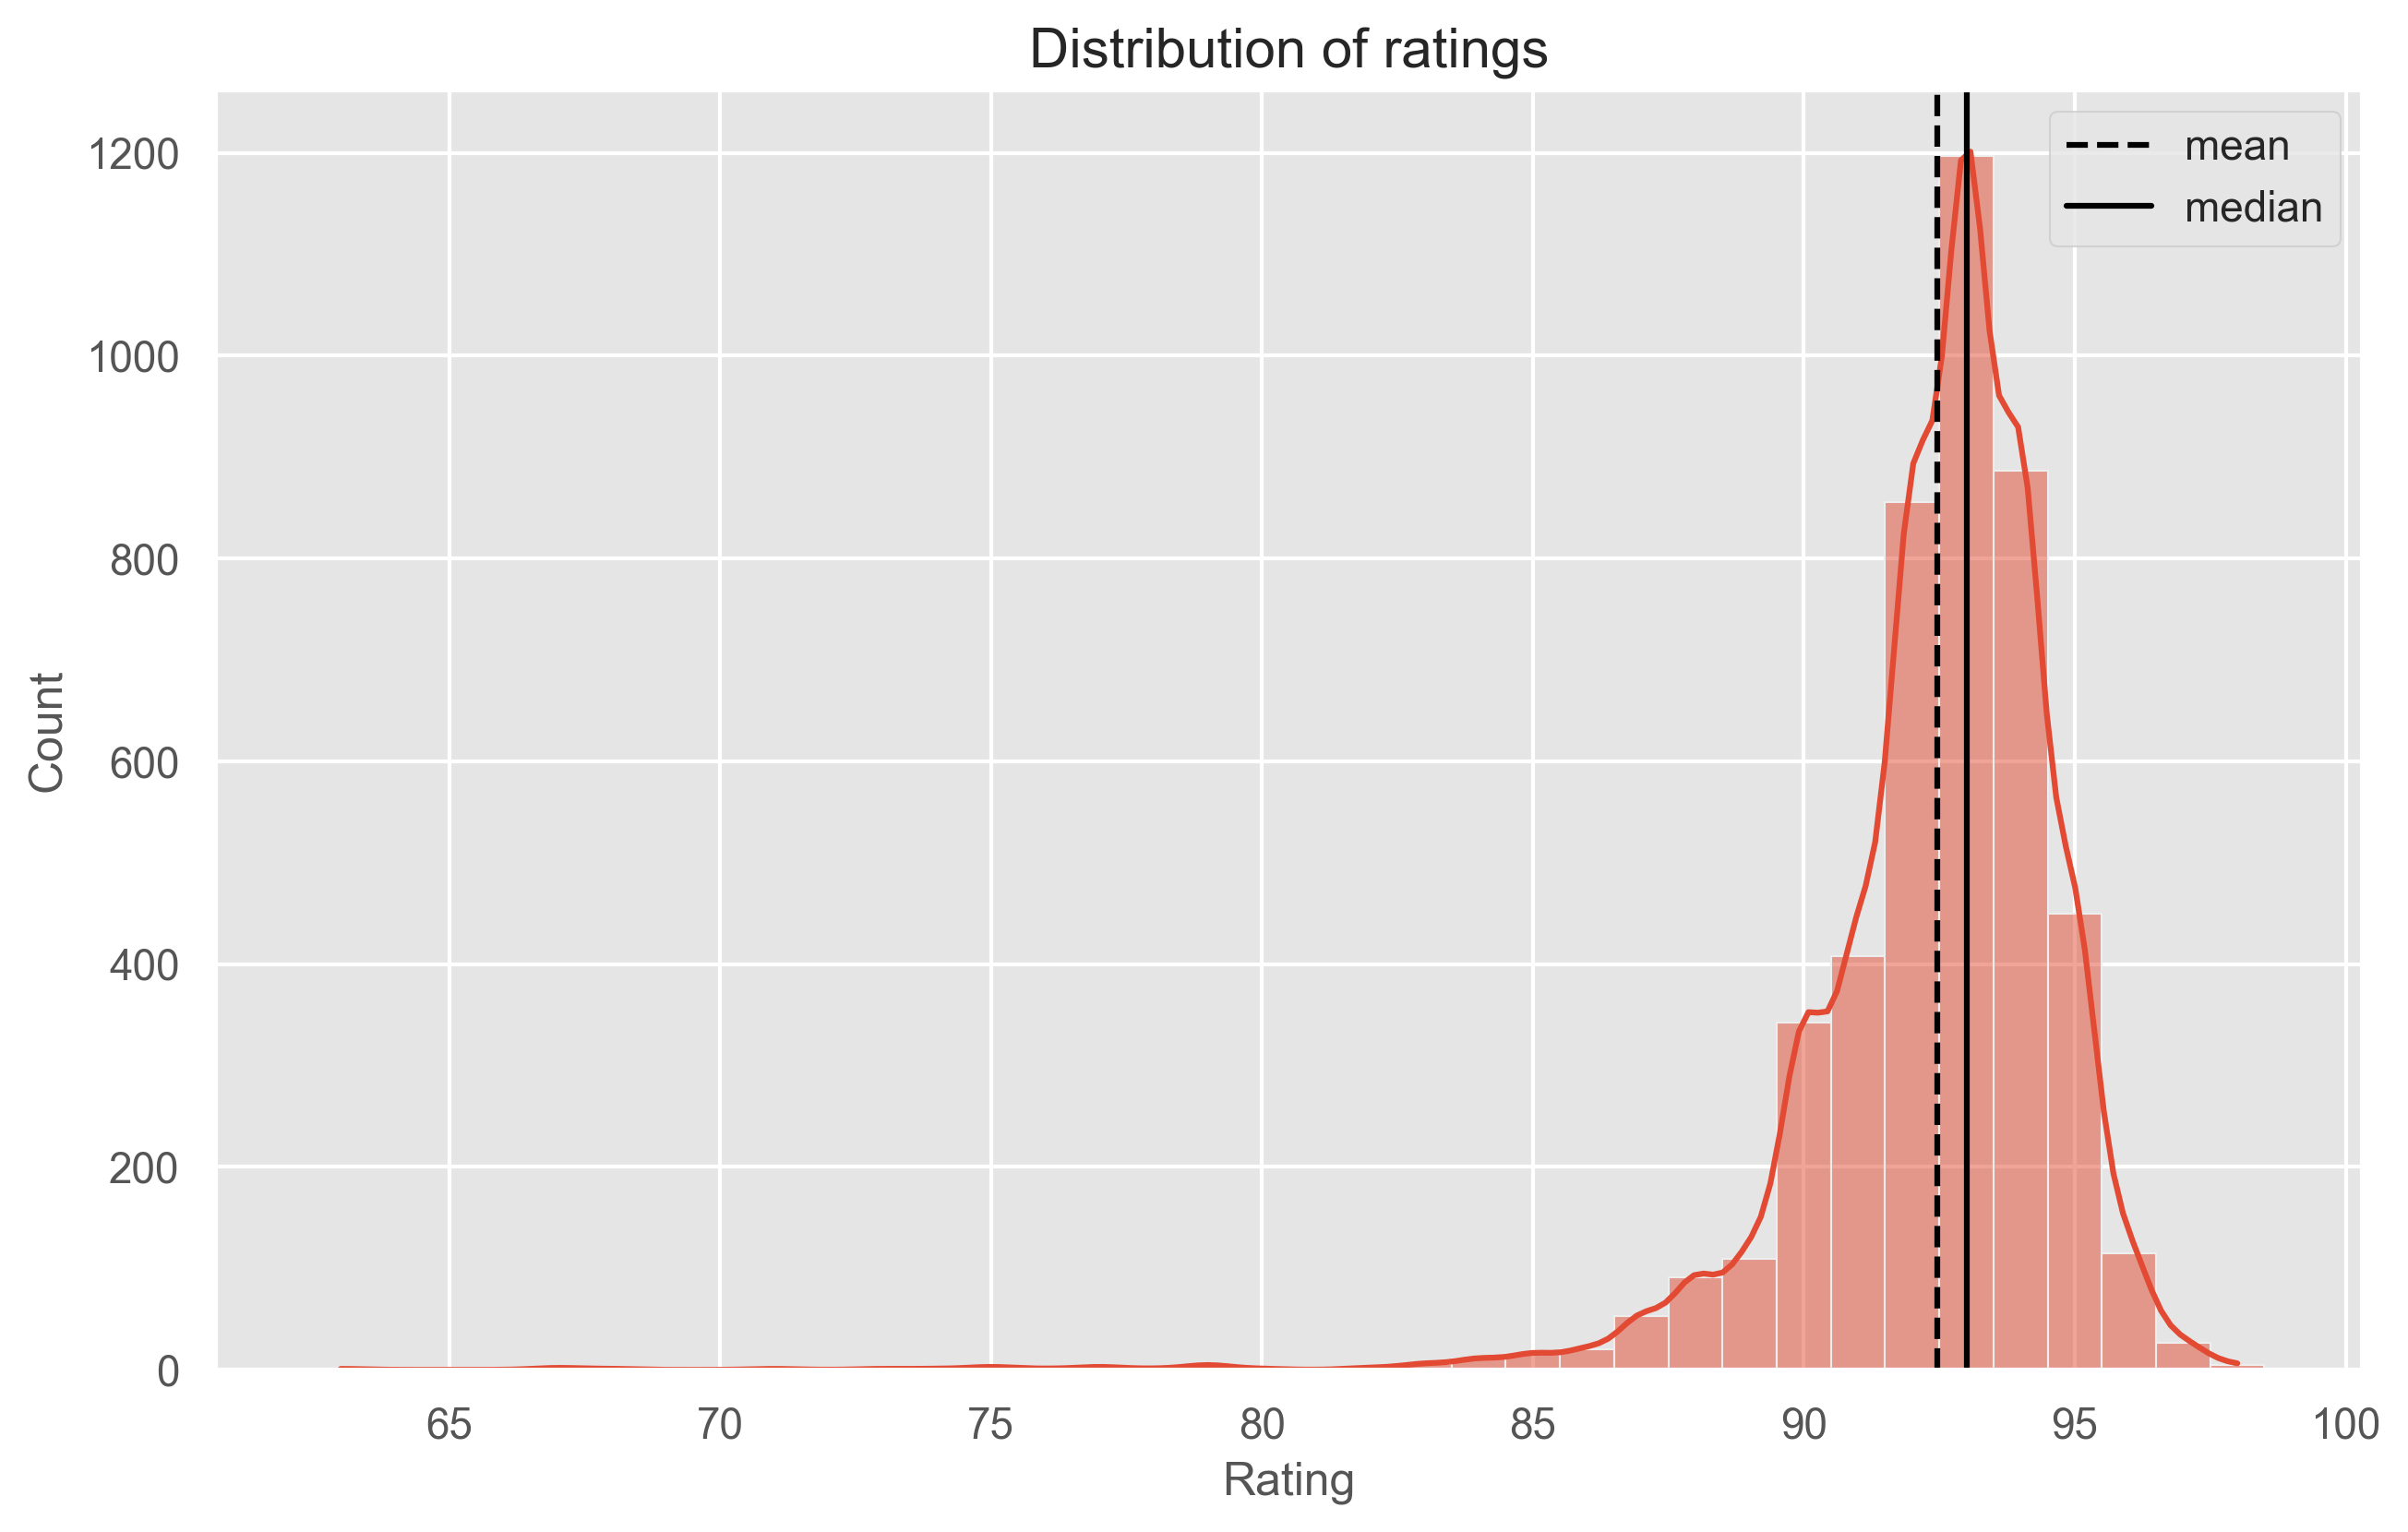

In [687]:
def plot_ratings_distribution(df):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df.astype({'rating':'float'}), x='rating',kde=True, discrete=True)
    ax.set_title('Distribution of ratings')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    ax.axvline(df['rating'].mean(), color='black', linestyle='--', label='mean')
    ax.axvline(df['rating'].median(), color='black', linestyle='-', label='median')
    ax.legend()
    plt.show()
    
plot_ratings_distribution(df)

In [ ]:
# plot number of reviews by country in seaborn
def plot_reviews_by_country(df):
    plt.figure(figsize=(10, 6))
    df = df.replace('Democratic Republic of the Congo', 'DRC')
    ax = sns.countplot(y='origin_country', data=df, order = df['origin_country'].value_counts().index)
    ax.bar_label(ax.containers[0], fontsize=6,)
    plt.yticks(fontsize=8)
    plt.title('Number of reviews by origin country')
    plt.xlabel('Number of reviews')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()

plot_reviews_by_country(df)

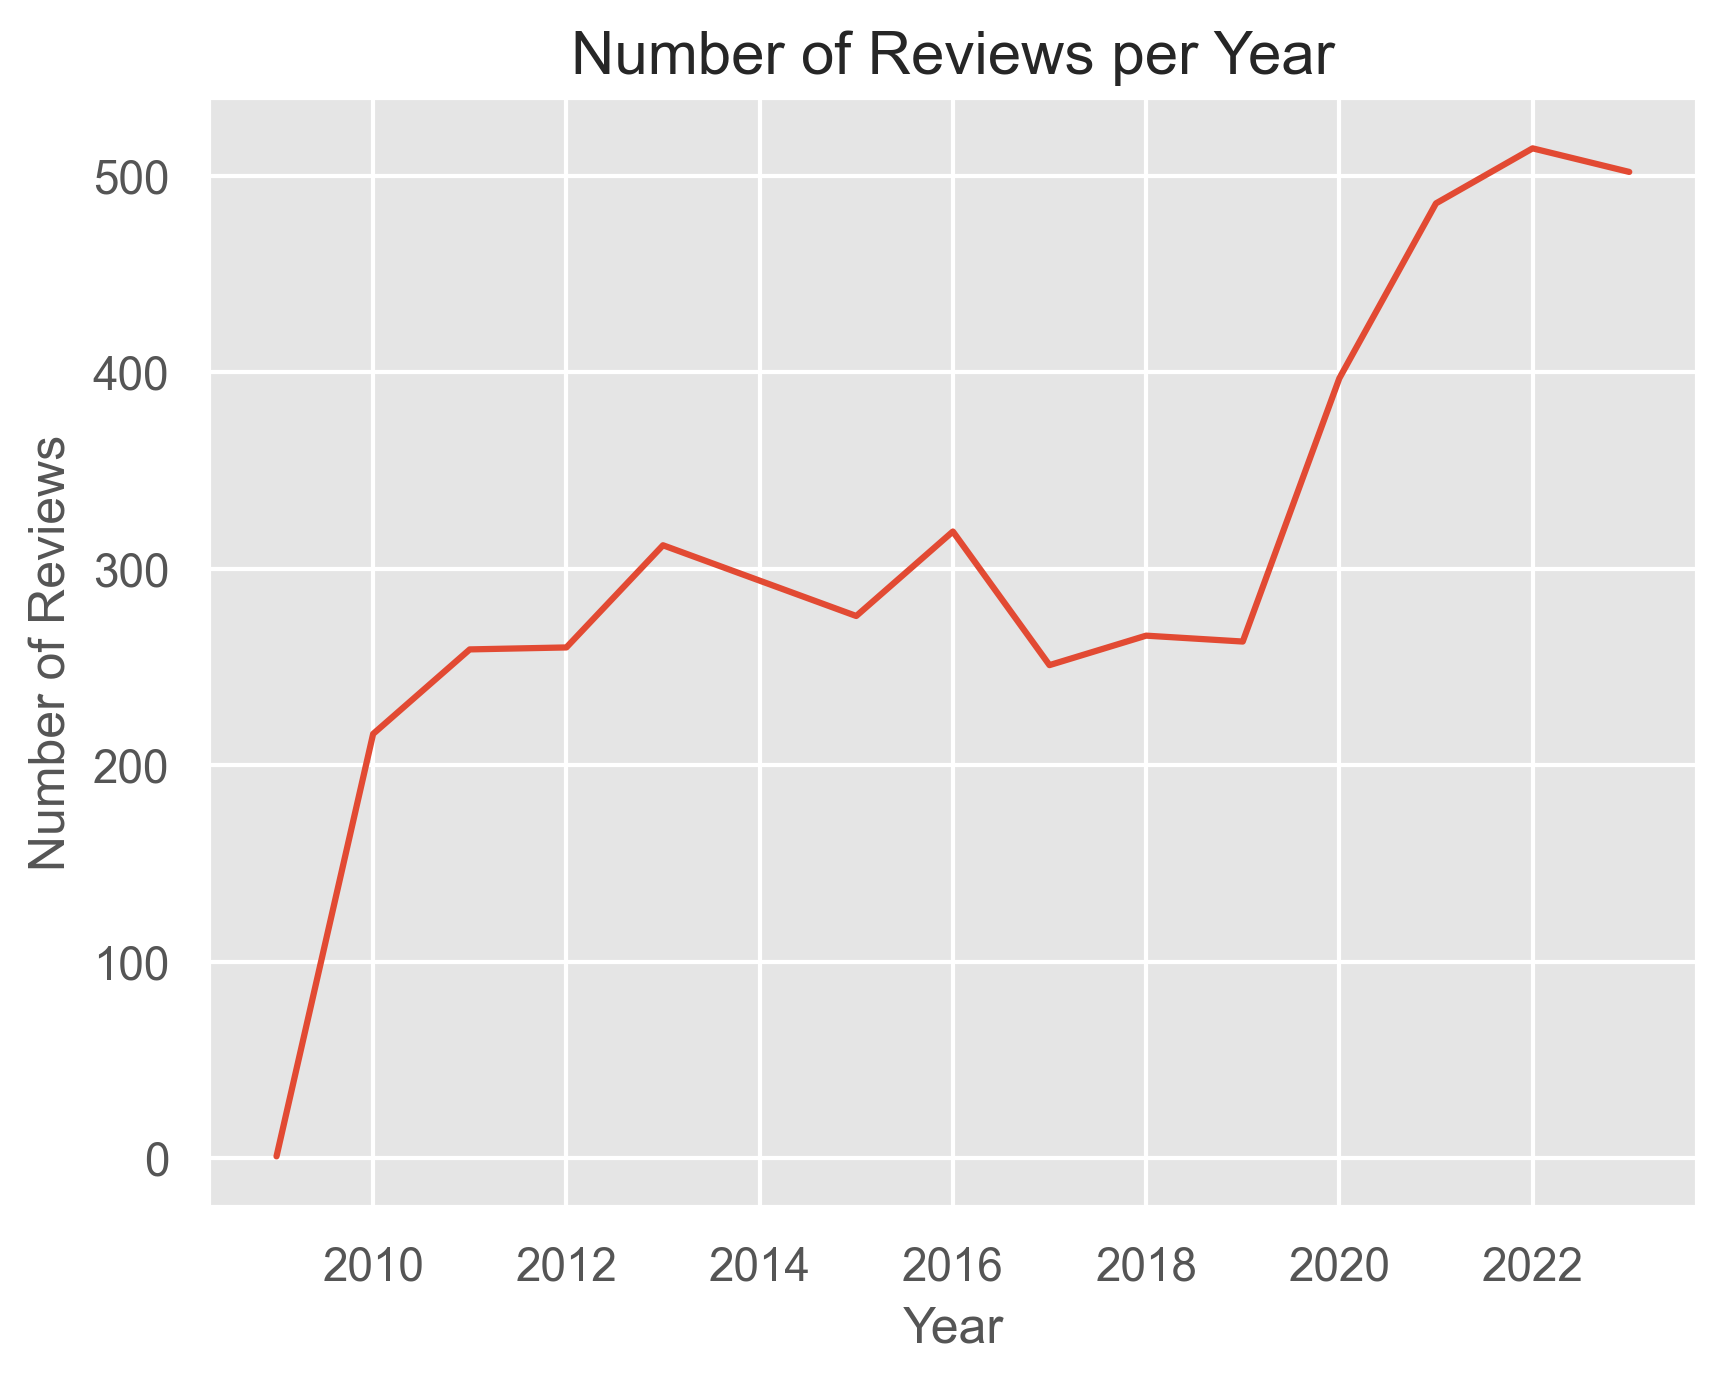

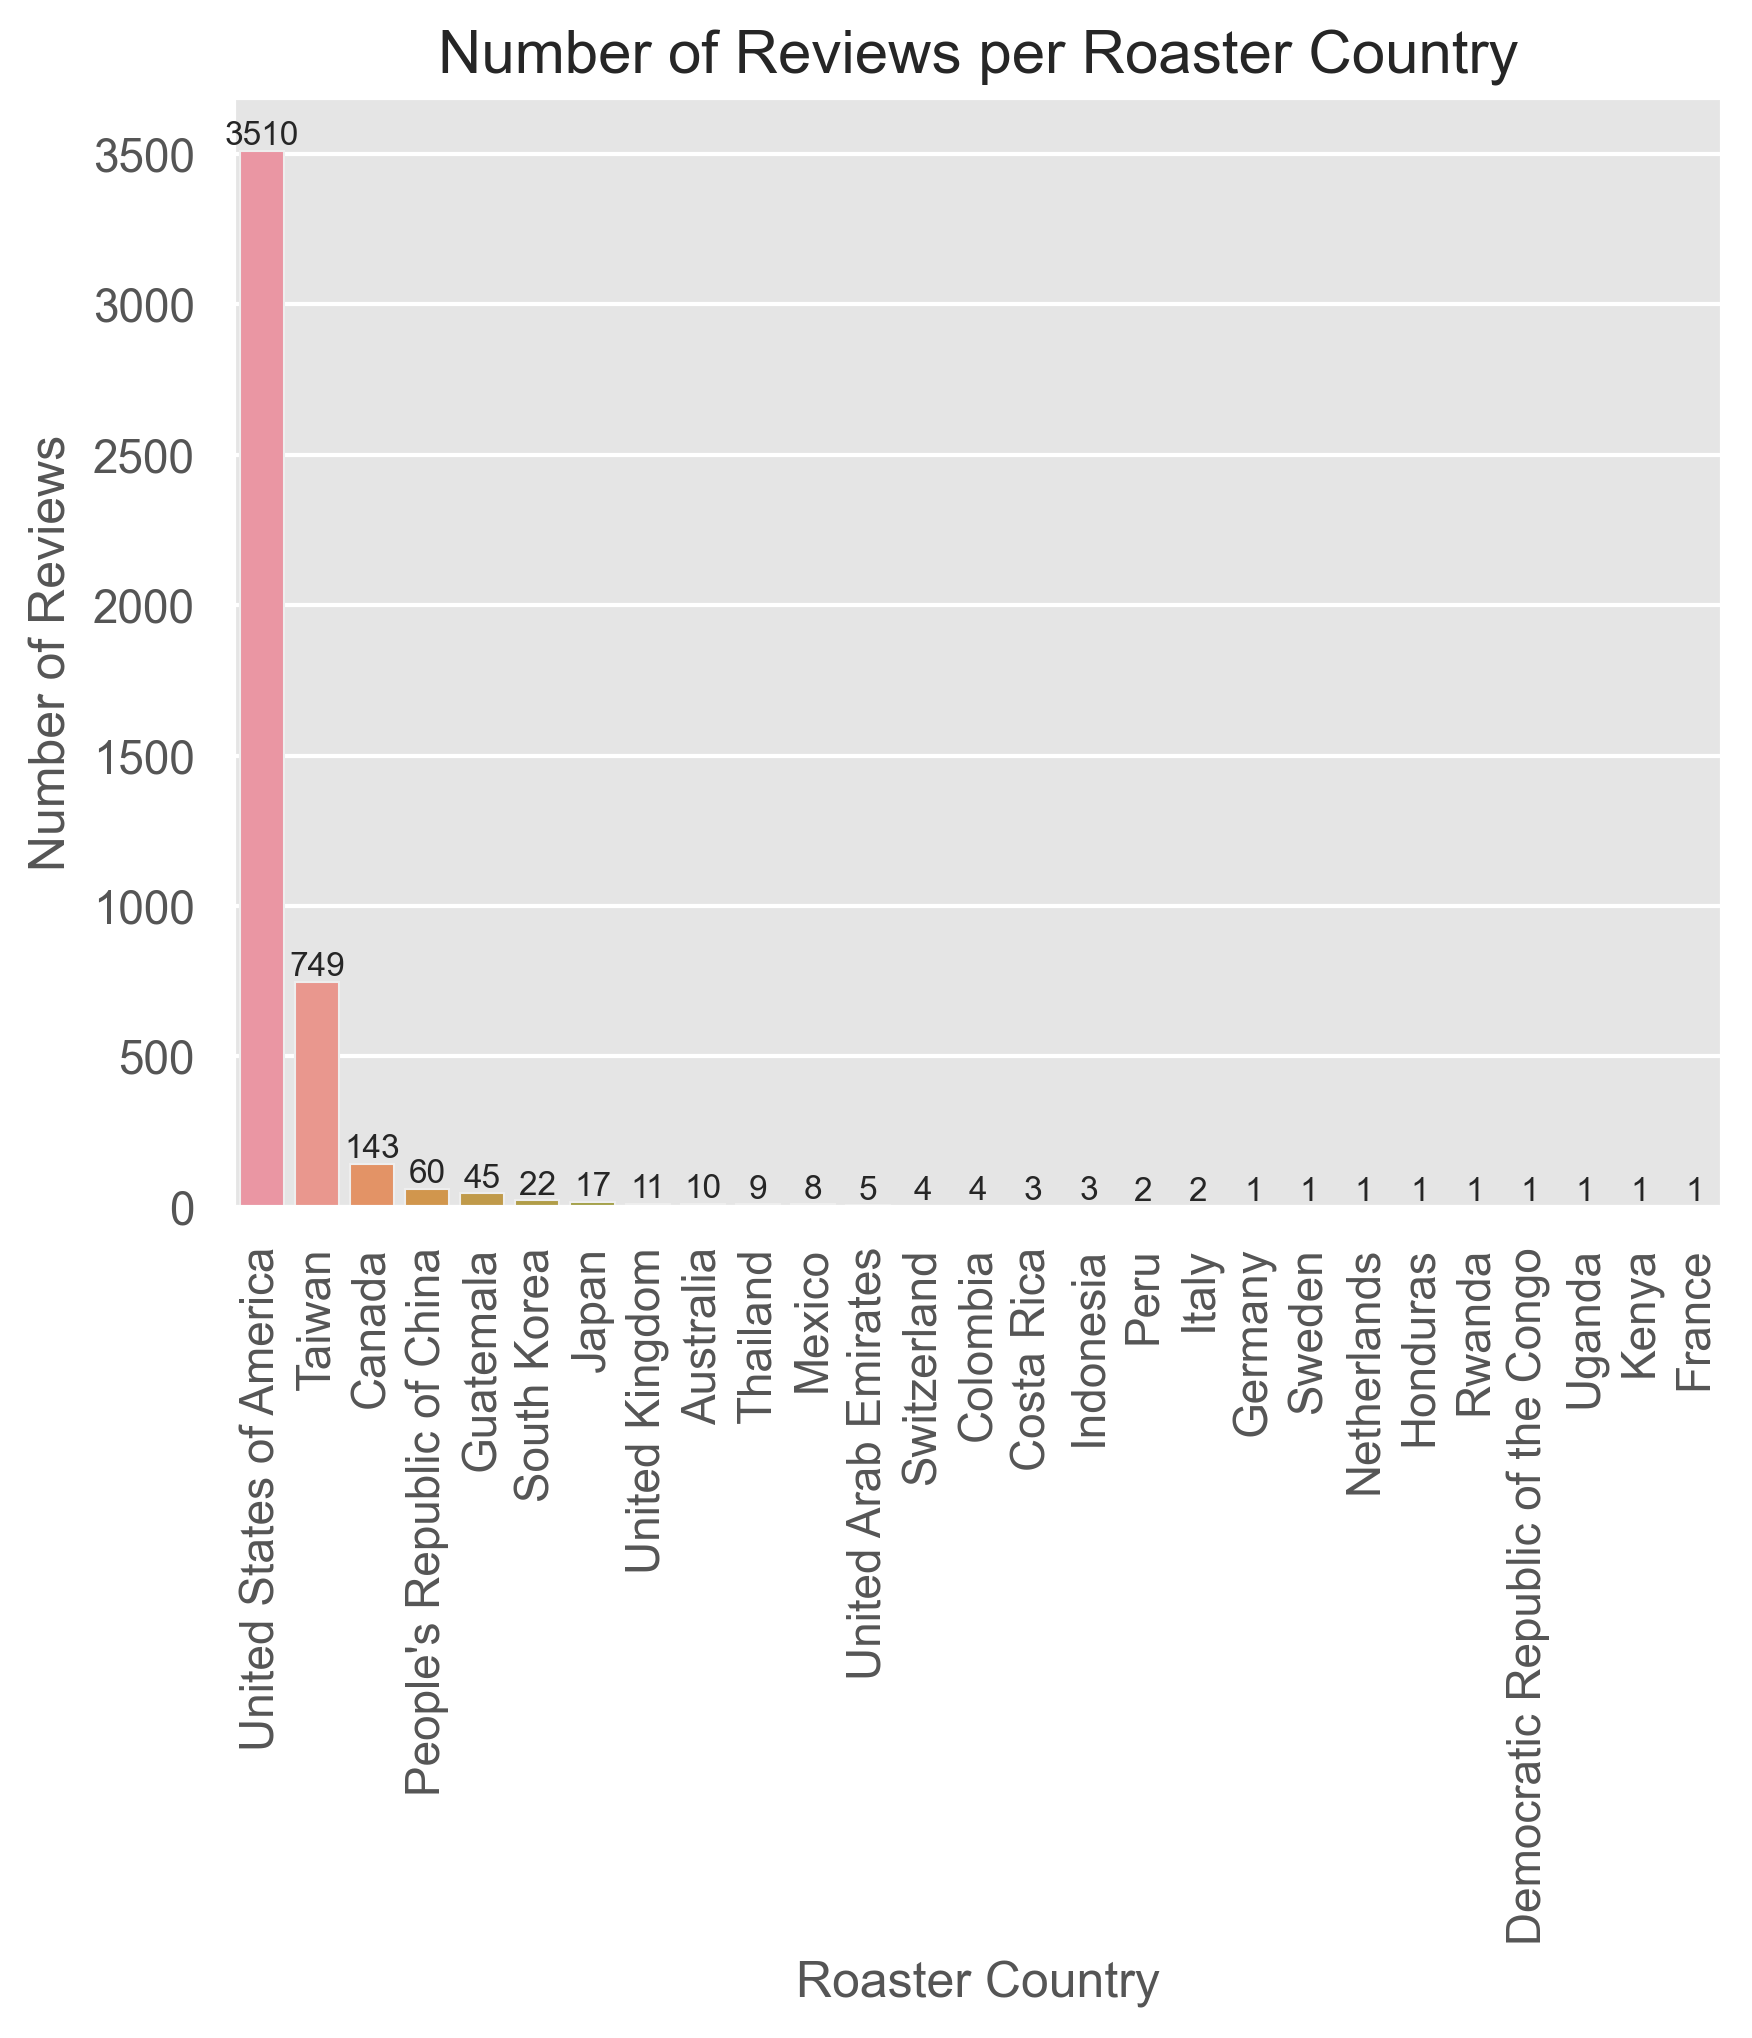

In [702]:
# PLot number of reviews per year. Plot Cumulative number of reviews on top of that.
# plot cumulative reviews over years in seaborn

fig, ax = plt.subplots()
year = df['review_date'].dt.year.value_counts().sort_index()
cumsum = df['review_date'].dt.year.value_counts().sort_index().cumsum()
sns.lineplot(x=year.index, y=year, ax=ax, )
ax.set_title('Number of Reviews per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Reviews')
plt.show()


# plot number of reviews per roaster_country ordered by number of reviews

fig, ax = plt.subplots()
country = df['roaster_country'].value_counts().sort_values(ascending=False)
sns.barplot(x=country.index, y=country, ax=ax, order=country.index)
ax.set_title('Number of Reviews per Roaster Country')
ax.set_xlabel('Roaster Country')
ax.set_ylabel('Number of Reviews')
plt.xticks(rotation=90)

for i,v in enumerate(country):
    ax.text(i, v+20, str(v), ha='center', fontsize=8)
plt.show()



## EDA

### Descriptive Statistics:
Calculate **basic statistics** like **mean, median, and standard deviation** for the 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste,' and 'Price' columns to get an overall understanding of the dataset. Find out how often different roasters and locations appear in the dataset. 

### Distributions:
Visualize the **distributions** of 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste' using to understand the spread of values.

### Correlations:
Investigate the **correlations** between different attributes such as 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste.' Identify which attributes tend to go together or have an impact on the overall rating.

### Top Roasters and Coffees:
Identify the top-rated roasters and coffee names based on the 'Rating' column. 

### Quantity Analysis:
Investigate the 'Quantity' and 'Unit' columns to understand the different packaging sizes and units in which coffee is sold. Analyze how these factors relate to pricing and consumer preferences.

### Roaster Performance:
Evaluate roasters' performance based on their ratings and the origin of the coffee beans. Are there specific regions or origins associated with higher ratings for particular roasters?

## Deeper Analysis:

### Geospatial Analysis:
Analyze the 'Roaster_Location' and 'Origin' columns to understand where the roasters are located and where the coffee beans are sourced from. You can use geospatial tools to create maps or investigate the relationship between origin and rating.

### Currency Analysis:
Analyze the 'Currency' column to understand the currencies used for pricing. You can convert prices to a common currency (e.g., USD) for comparison.

### Price Analysis:
Analyze the relationship between 'Price' and 'Rating.' Do higher-priced coffees tend to have higher ratings? You can also look for outliers in pricing.Investigate the relationship between pricing ('Price' and 'Currency') and sensory attributes ('Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste'). Are there pricing strategies associated with higher ratings?

### Text Analysis:
Perform natural language processing (NLP) on the 'Review_Description,' 'Blind_Assessment,' and 'Notes' columns to extract insights about the sensory descriptions, flavor profiles, and unique characteristics of the coffees.

0
USD    3728
TWD     680
CAD     103
HKD      24
KRW      19
CNY      14
GBP      11
JPY      11
AUD      10
AED       5
THB       5
IDR       3
MXN       1
EUR       1
GTQ       1
Name: count, dtype: int64